In [2]:
# setup
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt
import os
import time

from hcgame.utils import *
from hcgame.data import mnist, stl

%matplotlib inline 
%load_ext autoreload
%autoreload 2

device = 'cuda'
seed = 0
torch.random.manual_seed(seed)
np.random.seed(seed)
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

## Online Kernel PCA

In [93]:
class KernelPCA(nn.Module):
    def __init__(self, m=784, n=64, alpha=1, lam=1e-1, eps=1e-3, device='cpu', dtype=torch.float):
        super().__init__()
        self.m = m
        self.n = n
        self.alpha = alpha
        self.lam = lam
        self.eps = eps

        # init params
        self.w = nn.Parameter(torch.randn(n, m, device=device, dtype=dtype))
        self.l = nn.Parameter(torch.eye(n, device=device, dtype=dtype))

    def f(self,x,y):
        return x.norm(dim=1).view(-1,1) * y.norm(dim=1).view(1,-1) * (cos_mat(x,y)**self.alpha)
    
    def energy(self, x, y):
        cyy = cor_mat(y,y)
        e1 = (y*self.f(x,self.w)).mean(0).sum() - 1/2*self.f(self.w,self.w).diag().sum()
        e2 = (self.l*cyy - 1/2*self.l**2).sum()
        e3 = (self.lam*cyy.diag()).sum()

        return e1 - 1/2*e2 - 1/2*e3
    
    def forward(self, x):
        b = self.f(x,self.w)
        eye = torch.eye(self.l.shape[0], device=x.device, dtype=x.dtype)
        l_inv = (self.l+self.lam*eye).inverse()

        return (b @ l_inv).detach()

    def train(self,loader,etaw=0.1,etal=0.1,n_iter=1000,print_iter=10,info=None):
        # logging utils
        if info is None:
            info = {'es': [], 'etaws': [], 'etals': [], 'gws': [], 'gls': [], 'ts': []}
        t0 = time.time()
        
        # train
        track_grad_(self.w)
        track_grad_(self.l)
        for i in range(n_iter):
            self.w.grad.zero_()
            self.l.grad.zero_()

            x = next(loader)
            y = self.forward(x)
            e = self.energy(x,y)
            e.backward()
            
            with torch.no_grad():
                self.w += etaw * self.w.grad # / self.w.grad.abs().mean()
                # self.w /= self.w.norm(dim=1,keepdim=True)
                self.l -= etal*self.l.grad # / self.l.grad.abs().mean()

            # log
            info['es'].append(e.item())
            info['gws'].append(self.w.grad.abs().mean().item())
            info['gls'].append(self.l.grad.abs().mean().item())
            
            t1 = time.time()
            info['ts'].append(t1-t0)
            t0 = t1
            
            # print
            if print_iter is not None and i % (n_iter // print_iter) == 0:
                print('{}/{}: e={:.4f}, gw={:.4f}, gl={:.4f}, t={:.4f}'.format(i, n_iter, e.item(), self.w.grad.abs().mean().item(), self.l.grad.abs().mean().item(), sum(info['ts'])))
                
        return info

In [94]:
class Loader(nn.Module):
    def __init__(self, x, batch_size=64):
        self.x = x
        self.batch_size = batch_size
        
    def __iter__(self):
        while True:
            if self.batch_size is None:
                yield x
            else:
                ixs = torch.randperm(len(self.x))[:self.batch_size]
                yield self.x[ixs]

## MNIST

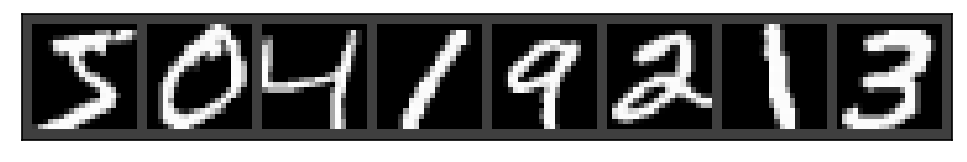

In [237]:
x1,l1,x2,l2,x3,l3 = mnist('cuda')[:6]
x = torch.cat([x1,x2,x3])
x = x[:,:,4:-4,4:-4]
x = tovec(x)
# x = x - x.mean(0)
x = x / x.std()
show_grid(toim(x)[:8])

## Train

In [315]:
torch.random.manual_seed(0)

loader = Loader(x,batch_size=64).__iter__()
net = KernelPCA(m=400, n=800, alpha=1, lam=1e-3, eps=1e-1, device='cuda')

In [316]:
# alpha = 1 warmup
net.alpha = 1
info = net.train(loader,etaw=0.01,etal=.1,n_iter=1000,print_iter=10)

0/1000: e=70050.8359, gw=9.4158, gl=89.5261, t=0.0243
100/1000: e=-3798.4846, gw=0.6190, gl=0.3493, t=1.5877
200/1000: e=57788.8438, gw=0.8730, gl=1.0344, t=3.0905
300/1000: e=175638.1094, gw=1.2350, gl=2.0143, t=4.5903
400/1000: e=383097.1250, gw=1.9243, gl=3.9644, t=6.0383
500/1000: e=652216.0625, gw=1.9796, gl=5.0825, t=7.4072
600/1000: e=1007134.0000, gw=2.3074, gl=5.4571, t=8.7775
700/1000: e=1301456.8750, gw=2.0394, gl=5.2401, t=10.1453
800/1000: e=1256350.2500, gw=2.6341, gl=7.4831, t=11.5113
900/1000: e=1551218.0000, gw=2.3516, gl=6.3136, t=12.8840


In [317]:
net.alpha=1
info = net.train(loader,etaw=0.001,etal=.01,n_iter=5000,print_iter=10, info=info)

0/5000: e=1540641.5000, gw=2.1320, gl=5.9879, t=14.2517
500/5000: e=32551.4160, gw=0.8214, gl=0.7774, t=21.1109
1000/5000: e=20267.8203, gw=0.4613, gl=0.3229, t=27.9545
1500/5000: e=17982.5156, gw=0.6024, gl=0.4940, t=34.8388
2000/5000: e=18405.6953, gw=0.6603, gl=0.5910, t=41.6929
2500/5000: e=13987.6123, gw=0.4082, gl=0.2859, t=48.6386
3000/5000: e=15773.9570, gw=0.5437, gl=0.4452, t=55.8450
3500/5000: e=13161.0664, gw=0.5052, gl=0.4090, t=63.0585
4000/5000: e=19197.7129, gw=0.5330, gl=0.4112, t=70.2739
4500/5000: e=15506.4531, gw=0.5995, gl=0.5045, t=77.4937


In [318]:
# info = net.train(loader,etaw=0.001,etal=.01,n_iter=5000,print_iter=10, info=info)

In [319]:
info = net.train(loader,etaw=0.0001,etal=.001,n_iter=5000,print_iter=10, info=info)

0/5000: e=16596.2031, gw=0.5990, gl=0.5164, t=84.7052
500/5000: e=14372.5342, gw=0.1014, gl=0.0426, t=92.0395
1000/5000: e=16107.2334, gw=0.0866, gl=0.0378, t=99.8199
1500/5000: e=15990.1787, gw=0.0957, gl=0.0387, t=107.0516
2000/5000: e=19400.8086, gw=0.1197, gl=0.0521, t=114.2010
2500/5000: e=17286.3555, gw=0.1099, gl=0.0477, t=121.0205
3000/5000: e=15635.0088, gw=0.0823, gl=0.0324, t=127.9638
3500/5000: e=19528.2578, gw=0.1098, gl=0.0462, t=135.3417
4000/5000: e=20818.9199, gw=0.1165, gl=0.0452, t=142.8805
4500/5000: e=22698.3809, gw=0.1144, gl=0.0456, t=150.5086


In [320]:
torch.save(net.state_dict(), './kernel-smatching-nets/n_800-alpha-1-v1-uncentered.pt')

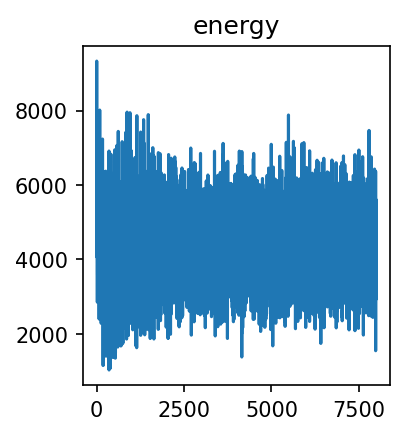

In [309]:
plt.figure(figsize=(9,3),dpi=150)
plt.subplot(131)
plt.plot(info['es'][-8000:])
plt.title('energy')

plt.show()

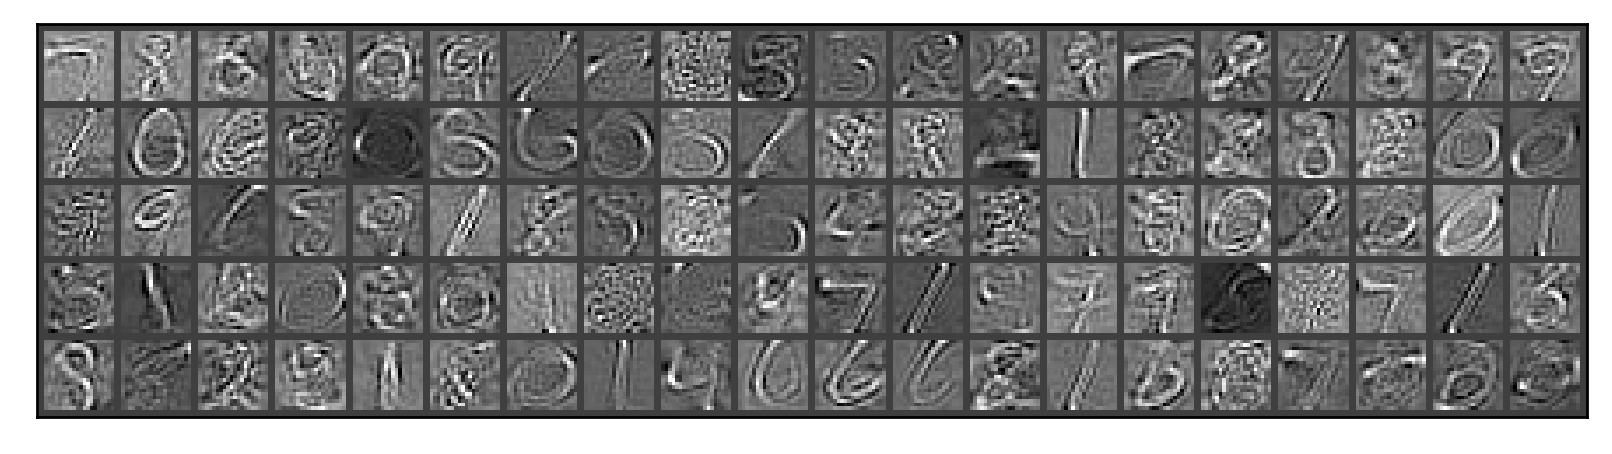

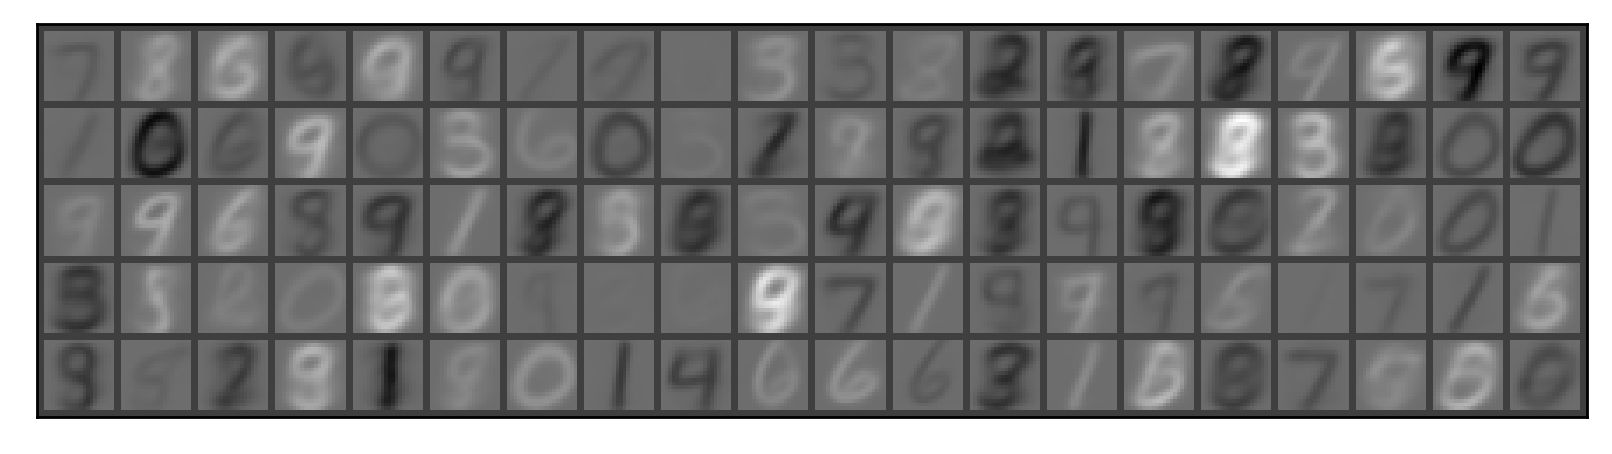

In [311]:
y = net(x)
wf = sta(x,y,1e-1)
show_grid(toim(wf[:100]),nrow=20, dpi=250, norm_every=True)
show_grid(toim(net.w[:100]),nrow=20,dpi=250, norm_every=False)

In [312]:
t = 512
y = net(x)
yy = y[:t] @ y[:t].t()
xx = x[:t] @ x[:t].t()
fxx = net.f(x[:t],x[:t])

In [313]:
fww = net.f(net.w,net.w)
u,s,v = fww.svd()
inv = u @ (1/s.clamp(1e-10)).diag() @ v.t()
ww = net.f(x[:t],net.w) @ inv @ net.f(net.w,x[:t])

fww = net.f(x[t:t+net.n],x[t:t+net.n])
u,s,v = fww.svd()
inv = u @ (1/s.clamp(1e-10)).diag() @ v.t()
wwt = net.f(x[:t],x[t:t+net.n]) @ inv @ net.f(x[t:t+net.n],x[:t])

print((fxx-yy).norm(), (fxx-ww).norm(), (fxx-wwt).norm())

tensor(2870.0581, device='cuda:0') tensor(6586.9800, device='cuda:0', grad_fn=<CopyBackwards>) tensor(2950.4834, device='cuda:0')


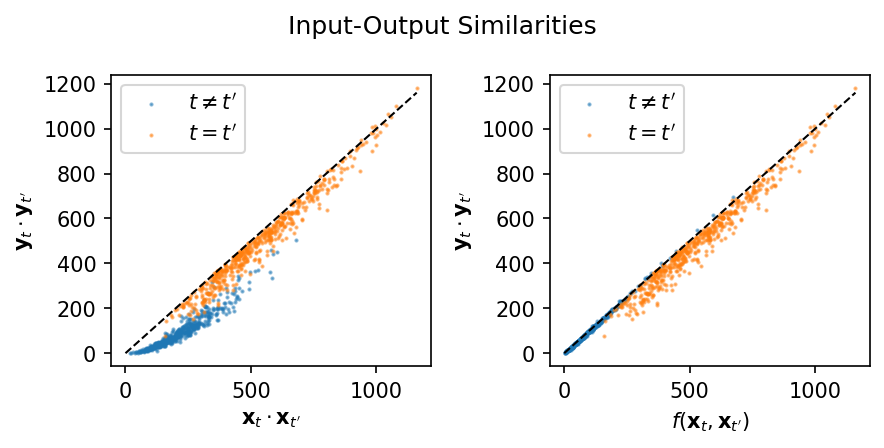

In [314]:
t = 512
y = net(x)
yy = y[:t] @ y[:t].t()
xx = x[:t] @ x[:t].t()
fxx = net.f(x[:t],x[:t])

plt.figure(figsize=(6,3),dpi=150)

plt.subplot(121)
ixs = torch.randperm(len(offdiag(xx)))[:t]
plt.scatter(offdiag(xx).detach().cpu().numpy()[ixs], offdiag(yy).detach().cpu().numpy()[ixs], s=1, alpha=0.5, label=r"$t \neq t'$")
plt.scatter(ondiag(xx).detach().cpu().numpy(), ondiag(yy).detach().cpu().numpy(), s=1, alpha=0.5, label="$t = t'$")
plt.plot(np.linspace(0,fxx.max().item()), np.linspace(0,fxx.max().item()), color='black', linewidth=1, linestyle='--')

plt.xlabel("$\mathbf{x}_{t} \cdot \mathbf{x}_{t'}$")
plt.ylabel("$\mathbf{y}_{t} \cdot \mathbf{y}_{t'}$")
plt.legend()

plt.subplot(122)
ixs = torch.randperm(len(offdiag(xx)))[:t]
plt.scatter(offdiag(fxx).detach().cpu().numpy()[ixs], offdiag(yy).detach().cpu().numpy()[ixs], s=1, alpha=0.5, label=r"$t \neq t'$")
plt.scatter(ondiag(fxx).detach().cpu().numpy(), ondiag(yy).detach().cpu().numpy(), s=1, label=r"$t = t'$", alpha=0.5)
plt.plot(np.linspace(0,fxx.max().item()), np.linspace(0,fxx.max().item()), color='black', linewidth=1, linestyle='--')

plt.xlabel("$f(\mathbf{x}_{t},\mathbf{x}_{t'})$")
plt.ylabel("$\mathbf{y}_{t} \cdot \mathbf{y}_{t'}$")
plt.legend()

plt.suptitle('Input-Output Similarities')
plt.tight_layout()

# plt.savefig('mnist-similarities.pdf')
plt.show()

In [253]:
(fxx-yy).norm(), (fxx-ww).norm(), (fxx-wwt).norm()

(tensor(12661.7783, device='cuda:0'),
 tensor(6432.3003, device='cuda:0', grad_fn=<CopyBackwards>),
 tensor(7821.2402, device='cuda:0'))

#### Histograms

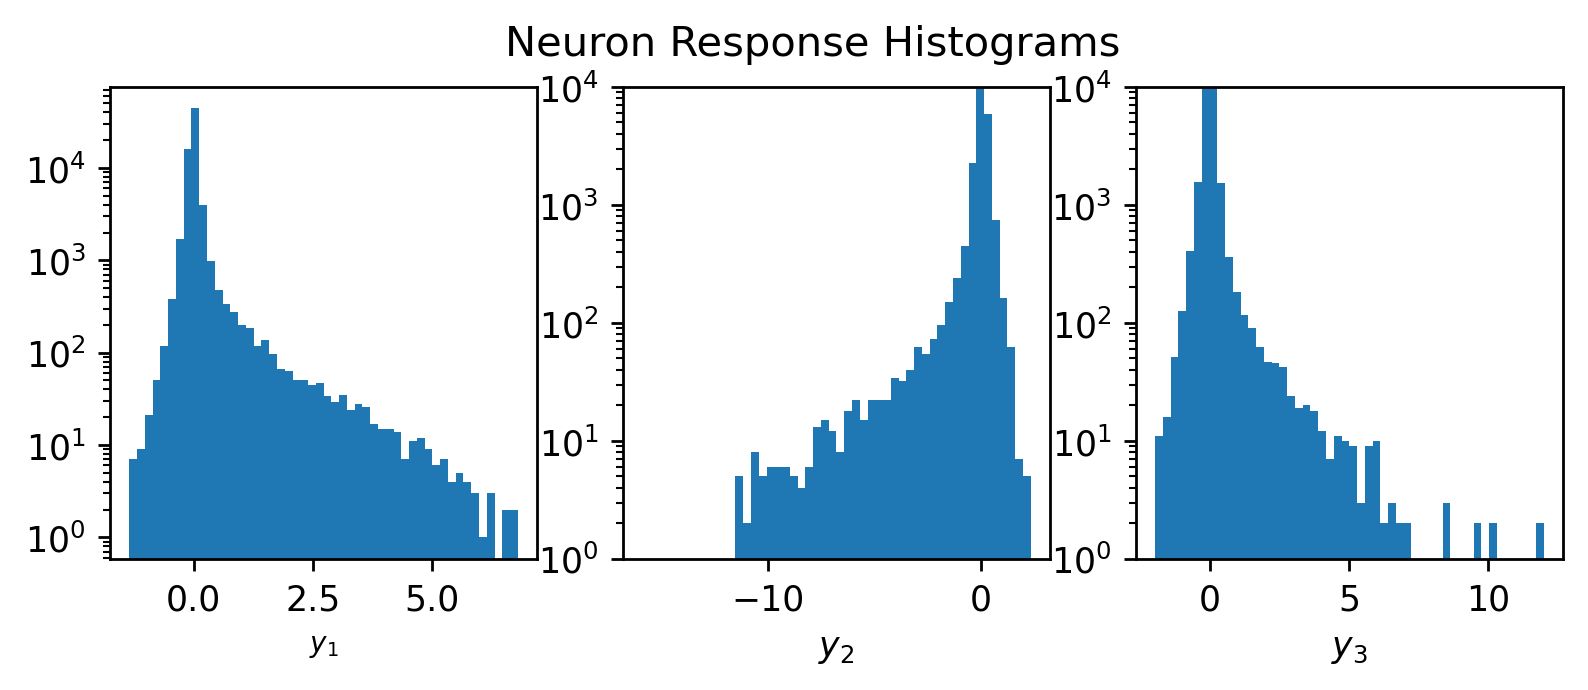

In [213]:
y = net(x)

plt.figure(figsize=(7.5,2.5),dpi=250)
plt.suptitle('Neuron Response Histograms')
plt.subplot(131)
plt.hist(y[:,0].cpu().numpy(),bins=50)
plt.yscale('log')
plt.xlabel('$y_1$', fontsize=8)

plt.subplot(132)
plt.hist(y[:,1].cpu().numpy(),bins=50)
plt.yscale('log')
plt.xlabel('$y_2$')
plt.ylim(1,10**4)

plt.subplot(133)
plt.hist(y[:,2].cpu().numpy(),bins=50)
plt.yscale('log')
plt.xlabel('$y_3$')
plt.ylim(1,10**4)

plt.show()

#### Eigenvalues

In [181]:
t = 10000
fxx = net.f(x[:t].cpu(),x[:t].cpu())

In [182]:
l,v = fxx.symeig()

In [183]:
lxx = cor_mat(x,x).symeig()[0].detach().cpu()
lyy = cor_mat(y,net(x)).symeig()[0].detach().cpu()

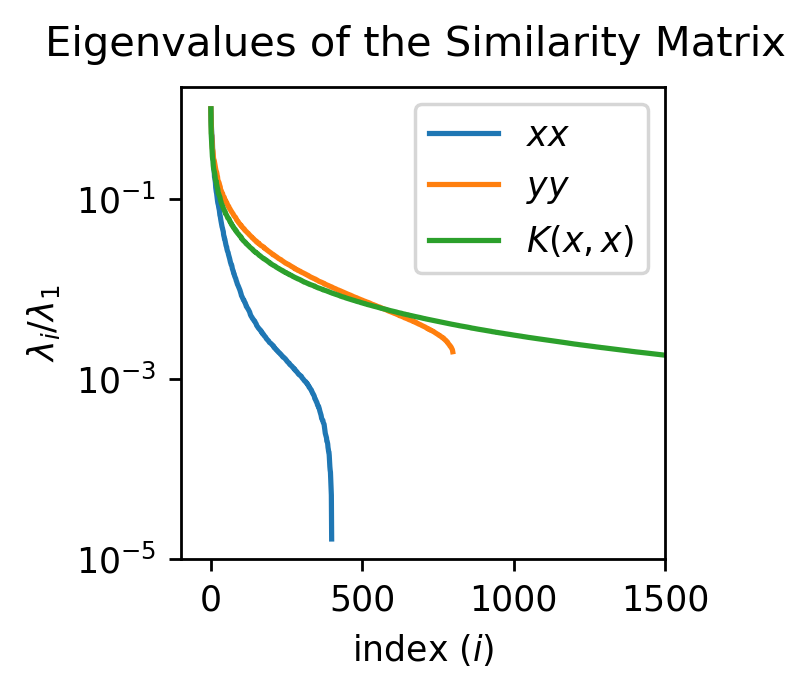

In [184]:
plt.figure(figsize=(2.5,2.5),dpi=250)
plt.suptitle('Eigenvalues of the Similarity Matrix')
plt.plot(lxx.flip(0) / lxx[-1], label='$xx$')
plt.plot(lyy.flip(0) / lyy[-1], label='$yy$')
plt.plot(l.flip(0) / l[-1], label='$K(x,x)$')

plt.yscale('log')
plt.ylim(1e-5,1.75)
plt.ylabel('$\lambda_i / \lambda_1$')

plt.xlabel('index $(i)$')
plt.xlim(-100,1500)
plt.legend()

plt.show()

#### Supervised Evaluation

In [185]:
from hcgame.classifiers import LogisticRegressionClassifier, NearestNeighborClassifier, accuracy_curve

def evaluate(u,u_,y,y_,seeds,ks):
    scores = {}
    for seed in seeds:
        for k in ks:
            # set seed
            torch.random.manual_seed(seed)

            # select data
            ut = torch.zeros(k*10,u.shape[1],dtype=u.dtype, device=u.device)
            yt = torch.zeros(k*10,dtype=y.dtype, device=y.device)
            for i in range(10):
                ixs = torch.where(y==i)[0]
                ixs = ixs[torch.randperm(len(ixs))[:k]]

                ut[i*k:(i+1)*k] = u[ixs].clone()
                yt[i*k:(i+1)*k] = y[ixs].clone()

            # train classifier
            clf = NearestNeighborClassifier('euclidean', 1)
            clf.train(ut,yt)
            s_trn,s_val = None, clf.score(u_,y_)

            # log result
            scores[seed,k] = (s_trn,s_val)
            print('seed: {}, k: {}, s_trn: {}, s_val: {}'.format(seed, k, s_trn, s_val))

    return scores

In [186]:
device = 'cpu'
seeds = [0]
ks = [1,3,10,30,100,300,1000,3000]

xscores_euc = evaluate(x[:40000].to(device), x[40000:].to(device), labels[:40000].to(device), labels[40000:].to(device),seeds,ks)
yscores_euc = evaluate(net(x[:40000]).to(device), net(x[40000:]).to(device), labels[:40000].to(device), labels[40000:].to(device),seeds,ks)

ModuleAttributeError: 'KernelPCA' object has no attribute 'x'

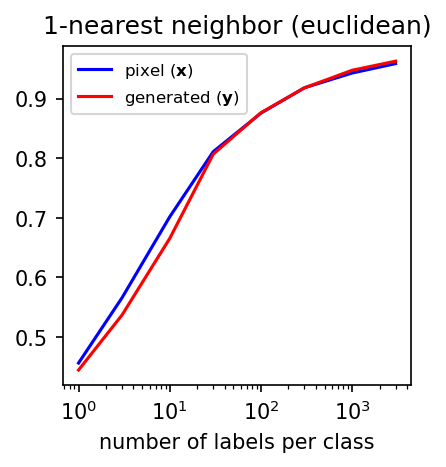

In [631]:
plt.figure(figsize=(3, 3), dpi=150)

plt.plot(ks, [sum([xscores_euc[seed,k][1] for seed in seeds])/len(seeds) for k in ks], color='blue', label='pixel ($\mathbf{x}$)')
plt.plot(ks, [sum([yscores_euc[seed,k][1] for seed in seeds])/len(seeds) for k in ks], color='red', label='generated ($\mathbf{y}$)')

plt.legend(fontsize=8)
plt.xscale('log')

plt.xlabel('number of labels per class')
plt.title('1-nearest neighbor (euclidean)')
plt.show()

#### Linear

In [632]:
from hcgame.classifiers import LogisticRegressionClassifier, accuracy_curve

def evaluate(u,u_,y,y_,seeds,ks,lams):
    scores = {}
    for seed in seeds:
        for k in ks:
            for lam in lams:
                # set seed
                torch.random.manual_seed(seed)

                # select data
                ut = torch.zeros(k*10,u.shape[1],dtype=u.dtype, device=u.device)
                yt = torch.zeros(k*10,dtype=y.dtype, device=y.device)
                for i in range(10):
                    ixs = torch.where(y==i)[0]
                    ixs = ixs[torch.randperm(len(ixs))[:k]]

                    ut[i*k:(i+1)*k] = u[ixs].clone()
                    yt[i*k:(i+1)*k] = y[ixs].clone()

                # train classifier
                clf = LogisticRegressionClassifier(u.shape[1],10,lam).to(u.device)
                clf.train(ut,yt)
                s_trn,s_val = clf.score(ut,yt), clf.score(u_,y_)

                # log result
                improved = s_val > scores.get((seed,k),(0,0,None))[1]
                if improved:
                    scores[seed,k] = (s_trn,s_val,lam)
                print('seed: {}, k: {}, lam: {}, s_trn: {}, s_val: {}, improved: {}'.format(seed, k, lam, s_trn, s_val, improved))

    return scores

In [633]:
device = 'cpu'
seeds = [0]
ks = [1,3,10,30,100,300,1000,3000]
lams = [1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1]

def normalize(x):
    return (x-x.mean(0)) / x.std()

xh = normalize(net.x)
yh = normalize(net.y)

xscores = evaluate(xh[:40000].to(device), xh[40000:].to(device), labels[:40000].to(device), labels[40000:].to(device),seeds,ks,lams)
yscores = evaluate(yh[:40000].to(device), yh[40000:].to(device), labels[:40000].to(device), labels[40000:].to(device),seeds,ks,lams)

seed: 0, k: 1, lam: 1e-05, s_trn: 1.0, s_val: 0.4932999908924103, improved: True
seed: 0, k: 1, lam: 0.0001, s_trn: 1.0, s_val: 0.49309998750686646, improved: False
seed: 0, k: 1, lam: 0.001, s_trn: 1.0, s_val: 0.4936000108718872, improved: True
seed: 0, k: 1, lam: 0.01, s_trn: 1.0, s_val: 0.4925999939441681, improved: False
seed: 0, k: 1, lam: 0.1, s_trn: 1.0, s_val: 0.49470001459121704, improved: True
seed: 0, k: 1, lam: 1.0, s_trn: 1.0, s_val: 0.49619999527931213, improved: True
seed: 0, k: 1, lam: 10.0, s_trn: 1.0, s_val: 0.4941999912261963, improved: False
seed: 0, k: 3, lam: 1e-05, s_trn: 1.0, s_val: 0.6013000011444092, improved: True
seed: 0, k: 3, lam: 0.0001, s_trn: 1.0, s_val: 0.5995000004768372, improved: False
seed: 0, k: 3, lam: 0.001, s_trn: 1.0, s_val: 0.5995000004768372, improved: False
seed: 0, k: 3, lam: 0.01, s_trn: 1.0, s_val: 0.6019999980926514, improved: True
seed: 0, k: 3, lam: 0.1, s_trn: 1.0, s_val: 0.6025000214576721, improved: True
seed: 0, k: 3, lam: 1.0, s_

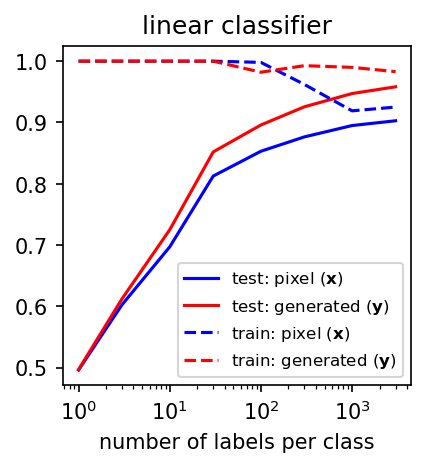

In [634]:
plt.figure(figsize=(3, 3), dpi=150)

plt.plot(ks, [sum([xscores[seed,k][1] for seed in seeds])/len(seeds) for k in ks], color='blue', label='test: pixel ($\mathbf{x}$)')
plt.plot(ks, [sum([yscores[seed,k][1] for seed in seeds])/len(seeds) for k in ks], color='red', label='test: generated ($\mathbf{y}$)')

plt.plot(ks, [sum([xscores[seed,k][0] for seed in seeds])/len(seeds) for k in ks], color='blue', label='train: pixel ($\mathbf{x}$)', linestyle='--')
plt.plot(ks, [sum([yscores[seed,k][0] for seed in seeds])/len(seeds) for k in ks], color='red', label='train: generated ($\mathbf{y}$)', linestyle='--')

plt.legend(fontsize=8)
plt.xscale('log')

plt.xlabel('number of labels per class')
plt.title('linear classifier')
plt.show()

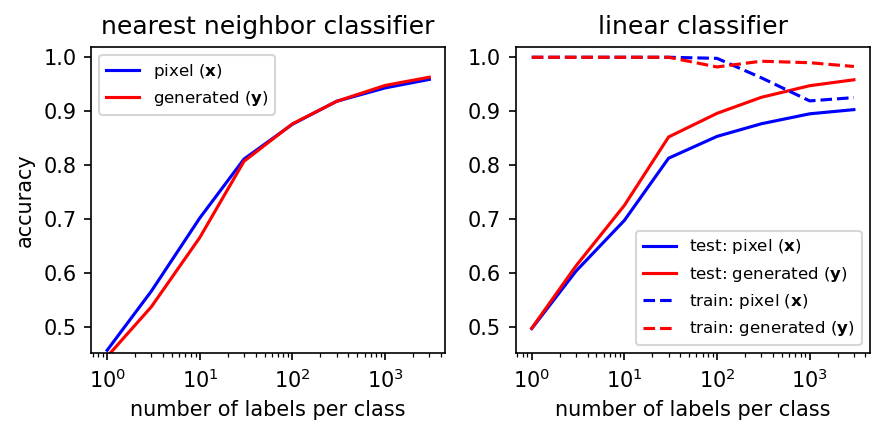

In [645]:
plt.figure(figsize=(6, 3), dpi=150)

plt.subplot(121)
plt.plot(ks, [sum([xscores_euc[seed,k][1] for seed in seeds])/len(seeds) for k in ks], color='blue', label='pixel ($\mathbf{x}$)')
plt.plot(ks, [sum([yscores_euc[seed,k][1] for seed in seeds])/len(seeds) for k in ks], color='red', label='generated ($\mathbf{y}$)')

plt.legend(fontsize=8)
plt.xscale('log')
plt.xlabel('number of labels per class')

plt.ylabel('accuracy')
plt.ylim(0.45,1.02)
plt.title('nearest neighbor classifier')

plt.subplot(122)
plt.plot(ks, [sum([xscores[seed,k][1] for seed in seeds])/len(seeds) for k in ks], color='blue', label='test: pixel ($\mathbf{x}$)')
plt.plot(ks, [sum([yscores[seed,k][1] for seed in seeds])/len(seeds) for k in ks], color='red', label='test: generated ($\mathbf{y}$)')

plt.plot(ks, [sum([xscores[seed,k][0] for seed in seeds])/len(seeds) for k in ks], color='blue', label='train: pixel ($\mathbf{x}$)', linestyle='--')
plt.plot(ks, [sum([yscores[seed,k][0] for seed in seeds])/len(seeds) for k in ks], color='red', label='train: generated ($\mathbf{y}$)', linestyle='--')

plt.legend(fontsize=8)
plt.xscale('log')
plt.xlabel('number of labels per class')

plt.ylim(0.45,1.02)
plt.title('linear classifier')
plt.tight_layout()

plt.savefig('mnist-supervised.pdf')
plt.show()